In [1]:
# Import the required packages
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
from dateutil import rrule
from dateutil.relativedelta import relativedelta
import yfinance as yf
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
yf.pdr_override()

In [2]:
# Get stock data
tickers = ['BTC-USD', 'ETC-USD', 'LTC-USD', 'XMR-USD', 'NEO-USD', 'XRP-USD', 'ZEC-USD']
df = pd.read_csv("stock.csv")

In [3]:
# Find two co-integrated stocks and return the second variable, which is the pValue of the co-integration pair
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    min_value = 1
    min_pair = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
                if pvalue < min_value:
                    min_value = pvalue
                    min_pair=[keys[i], keys[j]]
                
    return score_matrix, pvalue_matrix, pairs, min_pair

In [4]:
# Calculate returns
def trade(split, b, S1, S2, date, window1, window2, principal, trade_times, show_pic):

    if (window1 == 0) or (window2 == 0):
        return 0
    
    target = b * S1 - S2
    
    if show_pic:
        target[:split].plot(figsize=(12,6))
        plt.axhline(target[:split].mean())
        plt.title(u'train dataset: b * S1 - S2')
        plt.show()
        
    
    ma1 = target.rolling(window=window1,
                               center=False).mean()
    ma2 = target.rolling(window=window2,
                               center=False).mean()
    std = target.rolling(window=window1,
                        center=False).std()
    zscore = (ma2 - ma1)/std
    
    #zscore = (ma2 - (window1*ma1-window2*ma2)/(window1-window2))/std
    
    if show_pic:
        zscore[:split].plot(figsize=(12,6))
        plt.axhline(zscore[:split].mean())
        plt.title(u'train dataset: b * S1 - S2 zscore')
        plt.show()
    
    open_signal = pd.Series([] * len(S1))
    open_signal = pd.Series([] * len(S1))
    close_signal = pd.Series([] * len(S1))
    
    
    open_signal2 = pd.Series([] * len(S1))
    open_signal2 = pd.Series([] * len(S1))
    close_signal2 = pd.Series([] * len(S1))

    countS1 = 0
    countS2 = 0
    S1_o = 0
    S2_o = 0
    has_socket = 0
    rets = 0
    k = 0
    
    next_date = date[len(target)-1]
    # target = b * S1 - S2
    #for i in range(len(target)):
    for i in range(split, len(target)):
        #print(zscore[i])
        if trade_times is not None and k>=trade_times:
            next_date = date[i]
            break
        # short S2
        if zscore[i] < -1 and has_socket==0:
            countS1 = principal*b/(S1[i]*b+S2[i])
            countS2 = -countS1 / b
                
            has_socket = 1
            S1_o = S1[i]
            S2_o = S2[i]
            
            open_signal[i] = zscore[i]
            open_signal2[i] = target[i]
        
        # short S1
        elif zscore[i] > 1 and has_socket==0:
            countS1 = - principal*b/(S1[i]*b+S2[i])
            countS2 = - countS1 / b
                
            has_socket = 2
            S1_o = S1[i]
            S2_o = S2[i]
            
            open_signal[i] = zscore[i]
            open_signal2[i] = target[i]
             
        elif (has_socket==1 and zscore[i]>-0.1) or (has_socket==2 and zscore[i]<0.1): 
            k+=1
            has_socket = 0
            rets += countS1 * (S1[i] - S1_o) + countS2 * (S2[i] - S2_o)
            countS1 = 0
            countS2 = 0
            S1_o = 0
            S2_o = 0
            close_signal[i] = zscore[i]
            close_signal2[i] = target[i]
            
            
    rets += countS1 * (S1[-1] - S1_o) + countS2 * (S2[-1] - S2_o)
    
    if countS1!=0:
        close_signal[i] = zscore[len(target)-1]
        close_signal2[i] = target[len(target)-1]

    if show_pic:
        zscore.plot(figsize=(12,6))
        open_signal.plot(color='r', linestyle='None', marker='^')
        open_signal.plot(color='r', linestyle='None', marker='^')
        close_signal.plot(color='g', linestyle='None', marker='^')
        plt.title(u'all dataset: b * S1 - S2 and zscore')
        plt.show()

        target.plot(figsize=(12,6))
        open_signal2.plot(color='r', linestyle='None', marker='^')
        open_signal2.plot(color='r', linestyle='None', marker='^')
        close_signal2.plot(color='g', linestyle='None', marker='^')
        plt.show()
    
    return principal, rets, next_date

In [5]:
def main(start_date, end_date, train_date_len, test_date_len=None, trade_times=None, long_win=30, short_win=5, principal=None, select=None):
    rets_list = []
    pairs_list = []
    
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d').date()
    temp_date = start_date + relativedelta(months=+train_date_len)
    i = 0
    
    while temp_date + relativedelta(days=+(test_date_len+10)) < end_date:
       
        df_cur = df
        df_cur = df_cur[df_cur["Date"] >= datetime.datetime.strftime(start_date, "%Y-%m-%d")]
        df_cur = df_cur[df_cur["Date"] < datetime.datetime.strftime(temp_date, "%Y-%m-%d")]

        # Select test data set
        df_next = df
        df_next = df_next[df_next["Date"] >= datetime.datetime.strftime(temp_date, "%Y-%m-%d")]
        if test_date_len is not None:
            next_date = temp_date + relativedelta(days=+test_date_len)
            next_date = datetime.datetime.strftime(next_date, "%Y-%m-%d")
            df_next = df_next[df_next["Date"] < next_date]
        
        split = len(df_cur)
        df_all = pd.concat([df_cur, df_next], axis=0)
        df_all["Date2"] = df_all['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())
        df_all.sort_values(by="Date2", inplace=True, ascending=True)
        df_all.set_index('Date', inplace=True)
        
        # The smaller the pvalue, the higher the integration degree
        df_cur.set_index('Date', inplace=True)
        scores, pvalues, pairs, min_pair = find_cointegrated_pairs(df_cur)

        if len(min_pair)==0:
            #rets_list.append(0)
            #pairs_list.append([])
            # If there are no integration pairs, use data one day later
            start_date = start_date + relativedelta(days=+1)
            temp_date = temp_date + relativedelta(days=+1)
            continue

        ## Select an integration pair
        name1 = min_pair[0]
        name2 = min_pair[1]
        
        # Calculate b
        # OLS for polynomial fitting
        S1= df_cur[name1]
        S2= df_cur[name2]
        S1 = sm.add_constant(S1)
        results = sm.OLS(S2, S1).fit() 
        S1 = S1[name1]
        b = results.params[name1]
        
        principal, rets, next_date = trade(split, b, df_all[name1], df_all[name2], df_all['Date2'], long_win, short_win, principal, trade_times, select==i)
        
        print("【{}】The first stock:{}, The second Stock{}，b = {}".format(i, name1, name2, b))
        print("Train date:{}     {}".format(start_date, temp_date))
        print("Trade date:{}     {}".format(temp_date, next_date))
        
        t1 = df_all[name1]*b
        t2 = df_all[name1]
        if select==i:
            t1.plot(figsize=(12,6))
            t2.plot(figsize=(12,6))
            plt.title(u'two sockets')
            plt.show()
        
        print("Principal{}, Return:{}, Rate:{}".format(principal, rets, rets/principal))
        print()
        print()
        if rets != 0:
            rets_list.append(rets)
        pairs_list.append([name1, name2])
        
        i+=1
        start_date = next_date-relativedelta(months=+train_date_len)
        temp_date = next_date
            
    return rets_list
        


# Parameters
* The first two times are the start and end times of the data
* train_date_len：train data set length
* test_date_len：test data set length
* trade_times：The limit of the number of times we trade in each turn. None indicates that there is no limit on the number of trades in test data set
* principal：Limit of the amount of securities and principal
* select：Select the number of attempts to find the problem, None means not to find the problem, show all results

In [6]:
rets_list = main("2018-01-01", "2021-12-31", train_date_len = 5, test_date_len = 30, trade_times = 3, long_win = 40, short_win = 4, principal = 1000000, select = None)
print("=============================================================================================")
total = 0
for i in rets_list:
    total += i
print("Total:{}".format(total))

【0】The first stock:ETC-USD, The second StockLTC-USD，b = 4.680567518108776
Train date:2018-01-01     2018-06-01
Trade date:2018-06-01     2018-06-30
Principal1000000, Return:-205359.0085406747, Rate:-0.20535900854067468


【1】The first stock:ETC-USD, The second StockNEO-USD，b = 4.086079343902497
Train date:2018-01-30     2018-06-30
Trade date:2018-06-30     2018-07-29
Principal1000000, Return:-25688.36449959982, Rate:-0.025688364499599818


【2】The first stock:ETC-USD, The second StockXMR-USD，b = 11.76806099695008
Train date:2018-02-28     2018-07-29
Trade date:2018-07-29     2018-08-27
Principal1000000, Return:130740.02084202436, Rate:0.13074002084202435


【3】The first stock:XMR-USD, The second StockNEO-USD，b = 0.375470644250193
Train date:2018-03-27     2018-08-27
Trade date:2018-08-27     2018-09-25
Principal1000000, Return:-98666.11238198917, Rate:-0.09866611238198916


【4】The first stock:XMR-USD, The second StockNEO-USD，b = 0.41865558275059395
Train date:2018-04-25     2018-09-25
Tra

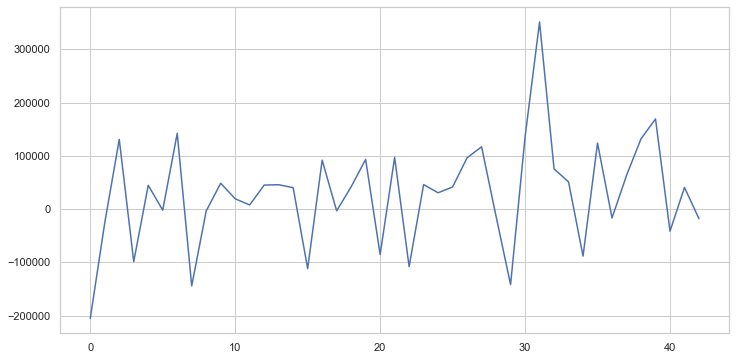

In [7]:
## pictures of returens for each transaction cycle
plt.figure(figsize = (12, 6))
plt.plot(rets_list)

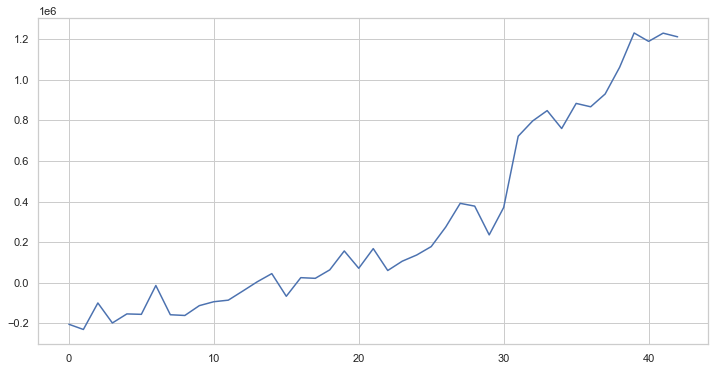

In [8]:
## pictures of accumulative returns from the first transaction cycle to the last
rets_acc = np.array(rets_list).cumsum(0)
plt.figure(figsize = (12, 6))
plt.plot(rets_acc)